## NYPD Data

### Imports

In [1]:
# data import
import pickle

# data manipulation
import numpy as np
import pandas as pd
from datetime import datetime

# plotting
import matplotlib.pyplot as plt

#gaussian filter
from scipy.ndimage import gaussian_filter

### Data Import

In [2]:
pickle_path = ('../raw_data/clean.pickle')
with open(pickle_path, 'rb') as f:
    df = pickle.load(f)
del pickle_path, f

### Sample Selection

In [3]:
inf = df['period'] > datetime(2016, 10, 1, 0, 0, 0)
sup = df['period'] < datetime(2016, 11, 1, 0, 0, 0)
sample = df[ inf & sup ]
del inf, sup, df

### Lat - Long to Array

In [4]:
def from_meters_to_coords(lat_meters, lon_meters):
    """
    gives the latitude and longitude step to use for the grid buckets
    lat_meters, lon_meters = lat/lon step
    """
    #Position, decimal degrees
    lat = 40
    lon = -73

    #Earth’s radius, sphere
    R=6378137

    #offsets in meters
    dn = lat_meters
    de = lon_meters

    #Coordinate offsets in radians
    dLat = dn/R
    dLon = de/(R*np.cos(np.pi*lat/180))

    #OffsetPosition, decimal degrees
    latO = dLat * 180/np.pi
    lonO = dLon * 180/np.pi 

    del lat, lon, R, dn, de, dLat, dLon

    return latO, lonO

In [5]:
def from_coord_to_matrix(df, lat_meters, lon_meters):
    """
    outputs the 3D matrix of all coordinates for a given bucket height and width in meters
    """
    df=df.copy()
    #add 'time_index' column to df
    ind = {time:index for index,time in enumerate(np.sort(df['period'].unique()))}
    df['time_index'] = df['period'].map(ind)
    
    #initiate matrix
    grid_offset = np.array([0, -40.91553277600008,  -74.25559136315213,]) # Where do you start
    #from meters to lat/lon step
    lat_spacing, lon_spacing = from_meters_to_coords(lat_meters, lon_meters )
    grid_spacing = np.array([1, lat_spacing , lon_spacing]) # What's the space you consider (euclidian here)
     
    
    #get points coordinates
    coords = np.array([(t_ind, -lat, lon) for t_ind, lat, lon \
                   in zip(df['time_index'],df['latitude'],df['longitude'])])
    
    
    # Convert point to index
    indexes = np.round((coords - grid_offset)/grid_spacing).astype('int')
    Z = indexes[:,0]
    Y = indexes[:,1]
    X = indexes[:,2]
    
    #virgin matrix
    a = np.zeros((Z.max()+1, Y.max()+1, X.max()+1))
   
    
    a[Z, Y, X]=1
    
    del ind, grid_offset, lat_spacing, lon_spacing, grid_spacing, coords, indexes, Z, Y, X
    
    return a, a.shape[1], a.shape[2]

In [6]:
img, lat_size, lon_size = from_coord_to_matrix(sample, 100, 100)
del sample

### Plotting Array (with and w/o Gaussian filter)

In [ ]:
#plt.figure(figsize=(5, 5))
#plt.imshow(img[3], cmap='gray');

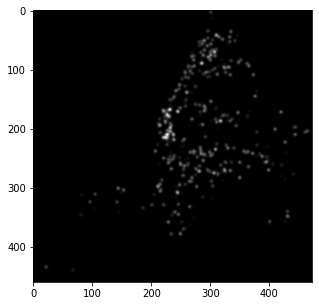

In [7]:
img3D_conv = gaussian_filter(img, sigma=(2, 2, 2))
del img

plt.figure(figsize=(5, 5))

plt.imshow(img3D_conv[3], cmap='gray');

### Splitting into X and y

In [8]:
def get_observation_target(img3D_conv, x_length, y_length):
    '''
    output an observation of x_length consecutive images and the y_length next images as the target
    '''
    position = np.random.randint(0, img3D_conv.shape[0] - (x_length + y_length))
    observation = img3D_conv[position:position + x_length]
    target = img3D_conv[position + x_length:position + (x_length + y_length)].flatten()
    
    del position 

    return observation, target

### Subsampling to get multiple X and y

In [9]:
def get_X_y(img3D_conv, number_of_observations, x_length, y_length):
    '''
    outputs n observations and their associated targets
    '''
    X = []
    y = []
    
    for n in range(number_of_observations):
        X_subsample, y_subsample = get_observation_target(img3D_conv, x_length, y_length)
        X.append(X_subsample)
        y.append(y_subsample)
        
    X = np.array(X)
    y = np.array(y)

    del X_subsample, y_subsample, n
    
    return X, y

In [10]:
x_length = 24
y_length= 3

X, y = get_X_y(img3D_conv, 100, x_length, y_length)
del img3D_conv

## Model

### Imports

In [11]:
# Train, test, split
from sklearn.model_selection import train_test_split

# Model
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

### Train, test, split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
del X,y

### Model

In [13]:
def model(x_length, y_length, lat_size, lon_size):
    print('initializing model')
    model = models.Sequential()
    
    print('adding gaussian noise')
    model.add(layers.GaussianNoise(stddev = 2.5, input_shape = (x_length, lat_size, lon_size)))
    
    print('adding conv2D 1')
    model.add(layers.Conv2D(64, kernel_size = 3, activation = 'relu'))

    print('adding conv2D 2')
    model.add(layers.Conv2D(32, kernel_size = 3, activation = 'relu'))

    print('adding conv2D 3')
    model.add(layers.Conv2D(16, kernel_size = 3, activation = 'relu'))

    print('flattening')
    model.add(layers.Flatten())
    
    print('adding dense layer 1')
    model.add(layers.Dense(50, activation = 'relu'))
    
    print('adding dense layer 2')
    model.add(layers.Dense(500, activation = 'relu'))
    
    print('adding dense layer 3')
    model.add(layers.Dense(y_length * lat_size * lon_size, activation = 'relu'))
    
    print('compiling')
    model.compile(loss = 'mse',
                      optimizer = 'adam',
                      metrics = 'mae')
    print('Done !')
    
    return model

### Running Model (Instance, Early Stopping, Fit and Evaluate)

**Reminders**

**batch_size:** no. of data used to compute error between y_pred and y_true each time weights of neural network updated (use 16 or 32)

**epoch:** once all data has been used once to update the weights

In [14]:
model = model(x_length,y_length, lat_size, lon_size)

initializing model
adding gaussian noise
adding conv2D 1
adding conv2D 2
adding conv2D 3
flattening
adding dense layer 1
adding dense layer 2
adding dense layer 3
compiling
Done !


In [ ]:
model.summary()

In [15]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                      batch_size = 16, 
                      epochs = 100,
                      validation_split = 0.3,
                      callbacks = es)

Epoch 1/100
4/4 [==============================] - 36s 9s/step - loss: 1.9124e-04 - mae: 0.0060 - val_loss: 1.2385e-06 - val_mae: 2.4757e-04
Epoch 2/100
4/4 [==============================] - 37s 9s/step - loss: 1.2507e-06 - mae: 2.4787e-04 - val_loss: 1.2378e-06 - val_mae: 2.4747e-04
Epoch 3/100
4/4 [==============================] - 34s 9s/step - loss: 1.2498e-06 - mae: 2.4775e-04 - val_loss: 1.2365e-06 - val_mae: 2.4731e-04
Epoch 4/100
4/4 [==============================] - 33s 8s/step - loss: 1.2484e-06 - mae: 2.4758e-04 - val_loss: 1.2349e-06 - val_mae: 2.4711e-04
Epoch 5/100
4/4 [==============================] - 33s 8s/step - loss: 1.2466e-06 - mae: 2.4737e-04 - val_loss: 1.2330e-06 - val_mae: 2.4689e-04
Epoch 6/100
4/4 [==============================] - 33s 8s/step - loss: 1.2446e-06 - mae: 2.4714e-04 - val_loss: 1.2310e-06 - val_mae: 2.4666e-04
Epoch 7/100
4/4 [==============================] - 35s 9s/step - loss: 1.2424e-06 - mae: 2.4691e-04 - val_loss: 1.2287e-06 - val_mae: 

4/4 [==============================] - 34s 9s/step - loss: 1.1713e-06 - mae: 2.4415e-04 - val_loss: 1.1628e-06 - val_mae: 2.4424e-04
Epoch 58/100
4/4 [==============================] - 34s 8s/step - loss: 1.1712e-06 - mae: 2.4419e-04 - val_loss: 1.1627e-06 - val_mae: 2.4428e-04
Epoch 59/100
4/4 [==============================] - 33s 8s/step - loss: 1.1711e-06 - mae: 2.4423e-04 - val_loss: 1.1626e-06 - val_mae: 2.4432e-04
Epoch 60/100
4/4 [==============================] - 33s 8s/step - loss: 1.1710e-06 - mae: 2.4426e-04 - val_loss: 1.1626e-06 - val_mae: 2.4435e-04
Epoch 61/100
4/4 [==============================] - 33s 8s/step - loss: 1.1709e-06 - mae: 2.4429e-04 - val_loss: 1.1625e-06 - val_mae: 2.4439e-04
Epoch 62/100
4/4 [==============================] - 32s 8s/step - loss: 1.1709e-06 - mae: 2.4432e-04 - val_loss: 1.1625e-06 - val_mae: 2.4441e-04
Epoch 63/100
4/4 [==============================] - 33s 8s/step - loss: 1.1708e-06 - mae: 2.4434e-04 - val_loss: 1.1625e-06 - val_mae: 2.

In [16]:
history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

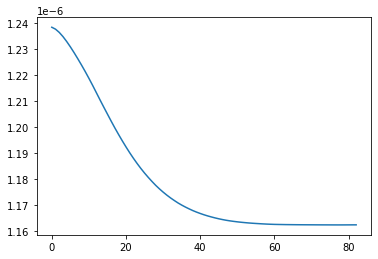

In [17]:
plt.plot(history.history['val_loss'])

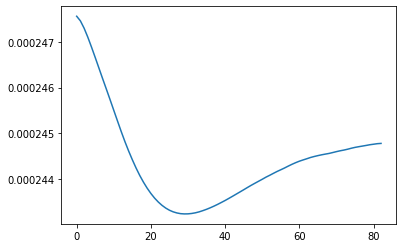

In [18]:
plt.plot(history.history['val_mae'])

In [19]:
print(model.evaluate(X_test, y_test))

1/1 [==============================] - 0s 2ms/step - loss: 1.2371e-06 - mae: 2.5378e-04
[1.23710901789309e-06, 0.00025377701967954636]
